In [535]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
from sklearn.metrics import r2_score 
import joblib

In [536]:
housing_data = pd.DataFrame(pd.read_csv("../data/housing_features.csv"))

In [537]:
housing_data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [538]:
housing_data.info()
# housing features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [539]:
housing_data.isnull().sum()*100/housing_data.shape[0]
# Data is already cleaned, no null values

price               0.0
area                0.0
bedrooms            0.0
bathrooms           0.0
stories             0.0
mainroad            0.0
guestroom           0.0
basement            0.0
hotwaterheating     0.0
airconditioning     0.0
parking             0.0
prefarea            0.0
furnishingstatus    0.0
dtype: float64

In [540]:
housing_data = pd.DataFrame(pd.read_csv("../data/housing_features.csv"))

varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

def binary_map(x):
    return x.map({'yes': 1, "no": 0})

housing_data[varlist] = housing_data[varlist].apply(binary_map)
housing_data

status = pd.get_dummies(housing_data['furnishingstatus'], drop_first = True).astype(int)
housing_data = pd.concat([housing_data, status], axis = 1)
housing_data.drop(['furnishingstatus'], axis = 1, inplace = True)
housing_data.drop(['area'], axis = 1, inplace = True)

housing_data.head()

,price,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,4,1,2,1,1,1,0,1,2,0,0,0


In [541]:
housing_data.to_csv('cleaned_housing_data.csv')

In [542]:
np.random.seed(42)
df_train, df_test = train_test_split(housing_data, train_size = 0.7, test_size = 0.3, random_state = 100)

In [543]:
scaler = MinMaxScaler()
num_vars = ['bedrooms', 'bathrooms', 'stories', 'parking','price']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
print(df_train[num_vars].iloc[0])

bedrooms     0.400000
bathrooms    0.000000
stories      0.000000
parking      0.333333
price        0.169697
Name: 359, dtype: float64


In [544]:
y_train = df_train.pop('price')
X_train = df_train

In [545]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [546]:
rfe = RFE(lm, step=6)
rfe = rfe.fit(X_train, y_train)

In [547]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('bedrooms', False, 2),
 ('bathrooms', True, 1),
 ('stories', True, 1),
 ('mainroad', False, 2),
 ('guestroom', False, 2),
 ('basement', False, 2),
 ('hotwaterheating', True, 1),
 ('airconditioning', True, 1),
 ('parking', True, 1),
 ('prefarea', True, 1),
 ('semi-furnished', False, 2),
 ('unfurnished', False, 2)]

In [548]:
col = X_train.columns[rfe.support_]
col

Index(['bathrooms', 'stories', 'hotwaterheating', 'airconditioning', 'parking',
       'prefarea'],
      dtype='object')

In [549]:
X_train.columns[~rfe.support_]

Index(['bedrooms', 'mainroad', 'guestroom', 'basement', 'semi-furnished',
       'unfurnished'],
      dtype='object')

In [550]:
X_train.columns[~rfe.support_]

Index(['bedrooms', 'mainroad', 'guestroom', 'basement', 'semi-furnished',
       'unfurnished'],
      dtype='object')

In [551]:
X_train_rfe = X_train[col]

In [552]:
X_train_rfe = sm.add_constant(X_train_rfe)

In [553]:
lm = sm.OLS(y_train,X_train_rfe).fit()

In [554]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     82.07
Date:                Fri, 19 Apr 2024   Prob (F-statistic):           3.44e-65
Time:                        16:25:27   Log-Likelihood:                 323.88
No. Observations:                 381   AIC:                            -633.8
Df Residuals:                     374   BIC:                            -606.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1137      0.009     

In [555]:
y_train_price = lm.predict(X_train_rfe)

In [556]:
res = (y_train_price - y_train)

/var/folders/j4/q2x8fn3d6tz1n4911kbm6g740000gn/T/ipykernel_74886/1861524926.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_train - y_train_price), bins = 20)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Errors')

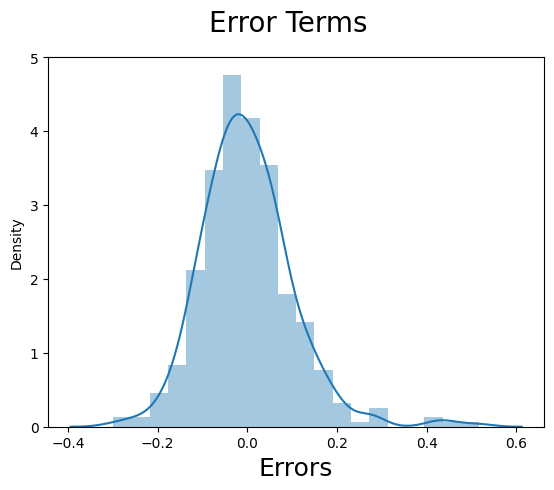

In [557]:
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18)

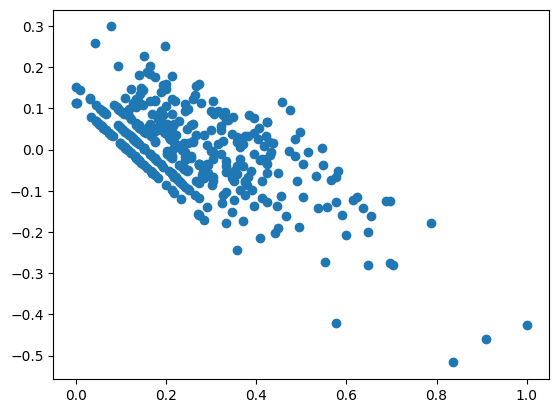

In [558]:
plt.scatter(y_train,res)
plt.show()

In [559]:
num_vars = ['stories', 'bathrooms', 'airconditioning', 'prefarea','parking','price']
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [560]:
y_test = df_test.pop('price')
X_test = df_test

In [561]:
X_test = sm.add_constant(X_test)

In [562]:
X_test_rfe = X_test[X_train_rfe.columns]

In [563]:
y_pred = lm.predict(X_test_rfe)
print(X_test_rfe.iloc[0])

const              1.000000
bathrooms          0.000000
stories            0.333333
hotwaterheating    0.000000
airconditioning    0.000000
parking            0.000000
prefarea           1.000000
Name: 265, dtype: float64


In [564]:
r2_score(y_test, y_pred)

0.5078489074898773

Text(0, 0.5, 'y_pred')

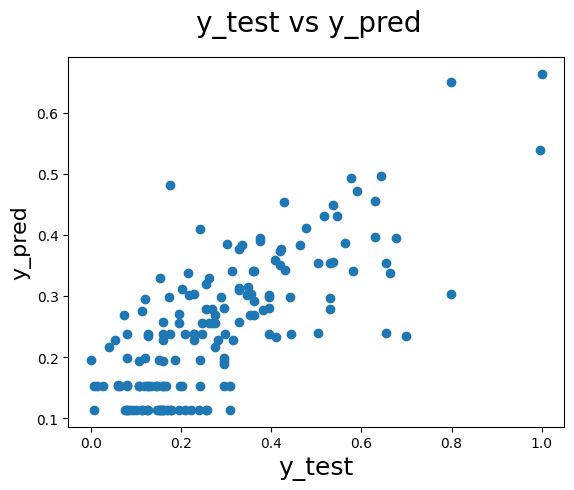

In [565]:
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)

In [566]:
joblib.dump(lm, 'model.pkl')

['model.pkl']

In [567]:
model = joblib.load('model.pkl')

In [568]:
print(X_test.iloc[0])

const              1.000000
bedrooms           3.000000
bathrooms          0.000000
stories            0.333333
mainroad           1.000000
guestroom          0.000000
basement           0.000000
hotwaterheating    0.000000
airconditioning    0.000000
parking            0.000000
prefarea           1.000000
semi-furnished     1.000000
unfurnished        0.000000
Name: 265, dtype: float64


In [581]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [592]:
prediction = model.predict(input)
min_value = scaler.data_min_[5]
max_value = scaler.data_max_[5]
print(min_value)
print(max_value)
print(prediction.to_numpy()[0] * (max_value - min_value) + min_value)

1820000.0
12250000.0
3706894.826498718


In [614]:
index = np.random.randint(low=0, high=len(X_test), size=1)[0]
print(index)
input = X_test.iloc[index][['const', 'bathrooms', 'stories', 'hotwaterheating', 'parking', 'airconditioning', 'prefarea']]
prediction = model.predict(input)
print(input)
dummy_features = pd.DataFrame(np.zeros((len(prediction), len(num_vars) - 1)), columns=num_vars[:-1])
inverse_df = pd.concat([dummy_features, prediction.rename('Target')], axis=1)

original_values = scaler.inverse_transform(inverse_df)
predictions = original_values[:, -1][1]
print(predictions)

first_row = df_test.iloc[index]
inverse_df = pd.DataFrame([first_row])[num_vars[:-1]]
target = pd.DataFrame([first_row])
inverse_df = pd.concat([dummy_features, pd.Series(y_test.iloc[index])], axis=1)
original_value = scaler.inverse_transform(inverse_df)
original_price = original_value[:, -1][0]
print(original_price)

14
const              1.000000
bathrooms          0.000000
stories            0.333333
hotwaterheating    0.000000
parking            0.000000
airconditioning    1.000000
prefarea           1.000000
Name: 150, dtype: float64
5763455.3674145965
5600000.0
